**IMPORT CSV**

In [3]:
import geopandas as gpd
import pandas as pd

In [4]:
# importing pandas package
import pandas as pd
 
# making data frame from csv file
df_csv = pd.read_csv('/Users/roniabuhanif/Downloads/BMKG/data_skripsi/kualitas_udara/pm10/pm10_satuan.csv')

**SET THE TIME TO .DATETIME FORMAT**

In [5]:
# overwriting data after changing format
df_csv['time']= pd.to_datetime(df_csv['time'])
 
# info of data
df_csv.info()
 
# display
print(df_csv.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       54000 non-null  datetime64[ns]
 1   latitude   54000 non-null  float64       
 2   longitude  54000 non-null  float64       
 3   pm10       54000 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.6 MB
        time  latitude  longitude       pm10
0 2018-01-01      -7.0     106.00  30.294199
1 2018-01-01      -7.0     106.05  31.531784
2 2018-01-01      -7.0     106.10  32.769369
3 2018-01-01      -7.0     106.15  34.006953
4 2018-01-01      -7.0     106.20  35.244538


In [6]:
df_csv['month'] = df_csv['time'].dt.month

In [7]:
df_csv['year'] = df_csv['time'].dt.year

**IMPORT SHP FILE**

In [8]:
# Load shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(r"/Users/roniabuhanif/Downloads/BMKG/data_skripsi/petadki_kota/Kota_DKIJakarta.shp")

**CREATE GEOMETRY FROM SHP AND CSV**

In [9]:
geometry = gpd.points_from_xy(df_csv['longitude'], df_csv['latitude'])
gdf_csv = gpd.GeoDataFrame(df_csv, geometry=geometry, crs='EPSG:4326')

<Axes: >

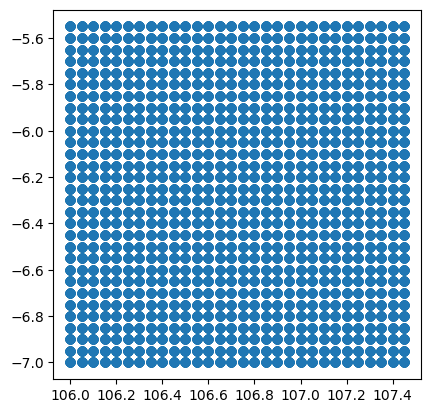

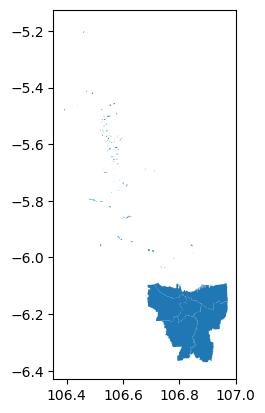

In [10]:
gdf_csv.plot()
gdf_shapefile.plot()

In [11]:
#join all the variables
result = gpd.sjoin(gdf_csv, gdf_shapefile, how='inner', predicate='intersects')

#add the columns
result_pop = result[['longitude', 'latitude', 'month', 'year', 'pm10', 'KABKOT', 'geometry', 'time']]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1440 entries, 406 to 53659
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   longitude  1440 non-null   float64       
 1   latitude   1440 non-null   float64       
 2   month      1440 non-null   int32         
 3   year       1440 non-null   int32         
 4   pm10       1440 non-null   float64       
 5   KABKOT     1440 non-null   object        
 6   geometry   1440 non-null   geometry      
 7   time       1440 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), geometry(1), int32(2), object(1)
memory usage: 90.0+ KB


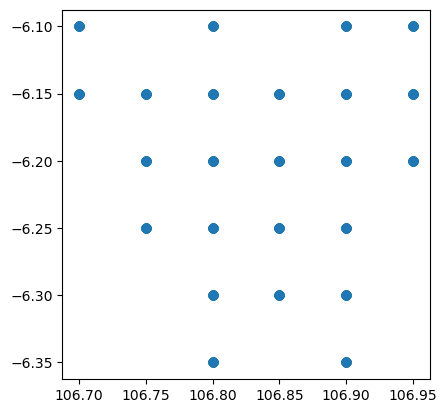

In [12]:
result_pop.plot()
result_pop.info()

**SHOW THE COLUMNS**

In [13]:
#input the columns to get the pm10 average/month
dissolved_result = result_pop.dissolve(by=['KABKOT','month'], aggfunc='mean')

dissolved_result.reset_index(inplace=True)
dissolved_result.head()

,KABKOT,month,geometry,longitude,latitude,year,pm10,time
0,JAKARTA BARAT,1,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,2020.0,54.820748,2020-01-01 09:36:00
1,JAKARTA BARAT,2,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,2020.0,58.284398,2020-02-01 09:36:00
2,JAKARTA BARAT,3,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,2020.0,65.689203,2020-02-29 14:24:00
3,JAKARTA BARAT,4,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,2020.0,79.537229,2020-03-31 14:24:00
4,JAKARTA BARAT,5,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,2020.0,87.775776,2020-04-30 14:24:00


In [14]:
#download data to .csv format
dissolved_result.to_csv('PM10_all_month.csv')

**SET FOR MAPPING**

In [15]:
# ubah per month
import pandas as pd

In [16]:
#change into dataframe to drop the 'geometry' columns, etc
dissolved_result_df= pd.DataFrame(dissolved_result)
dissolved_result_df = dissolved_result_df.drop(['geometry'], axis = 1)

In [17]:
dissolved_result_df = dissolved_result_df.sort_values(by=['KABKOT', 'month'])

In [18]:
#download data to .csv format
dissolved_result_df.to_csv('pm10_kabkot_month.csv')

In [19]:
polygon_result = gpd.sjoin(gdf_shapefile, dissolved_result, how='inner', predicate='intersects')
print(polygon_result.columns)

Index(['PROVNO', 'KABKOTNO', 'PROVINSI', 'KABKOT_left', 'geometry',
       'index_right', 'KABKOT_right', 'month', 'longitude', 'latitude', 'year',
       'pm10', 'time'],
      dtype='object')


**MAPPING**

In [20]:
import calendar
import matplotlib.pyplot as plt

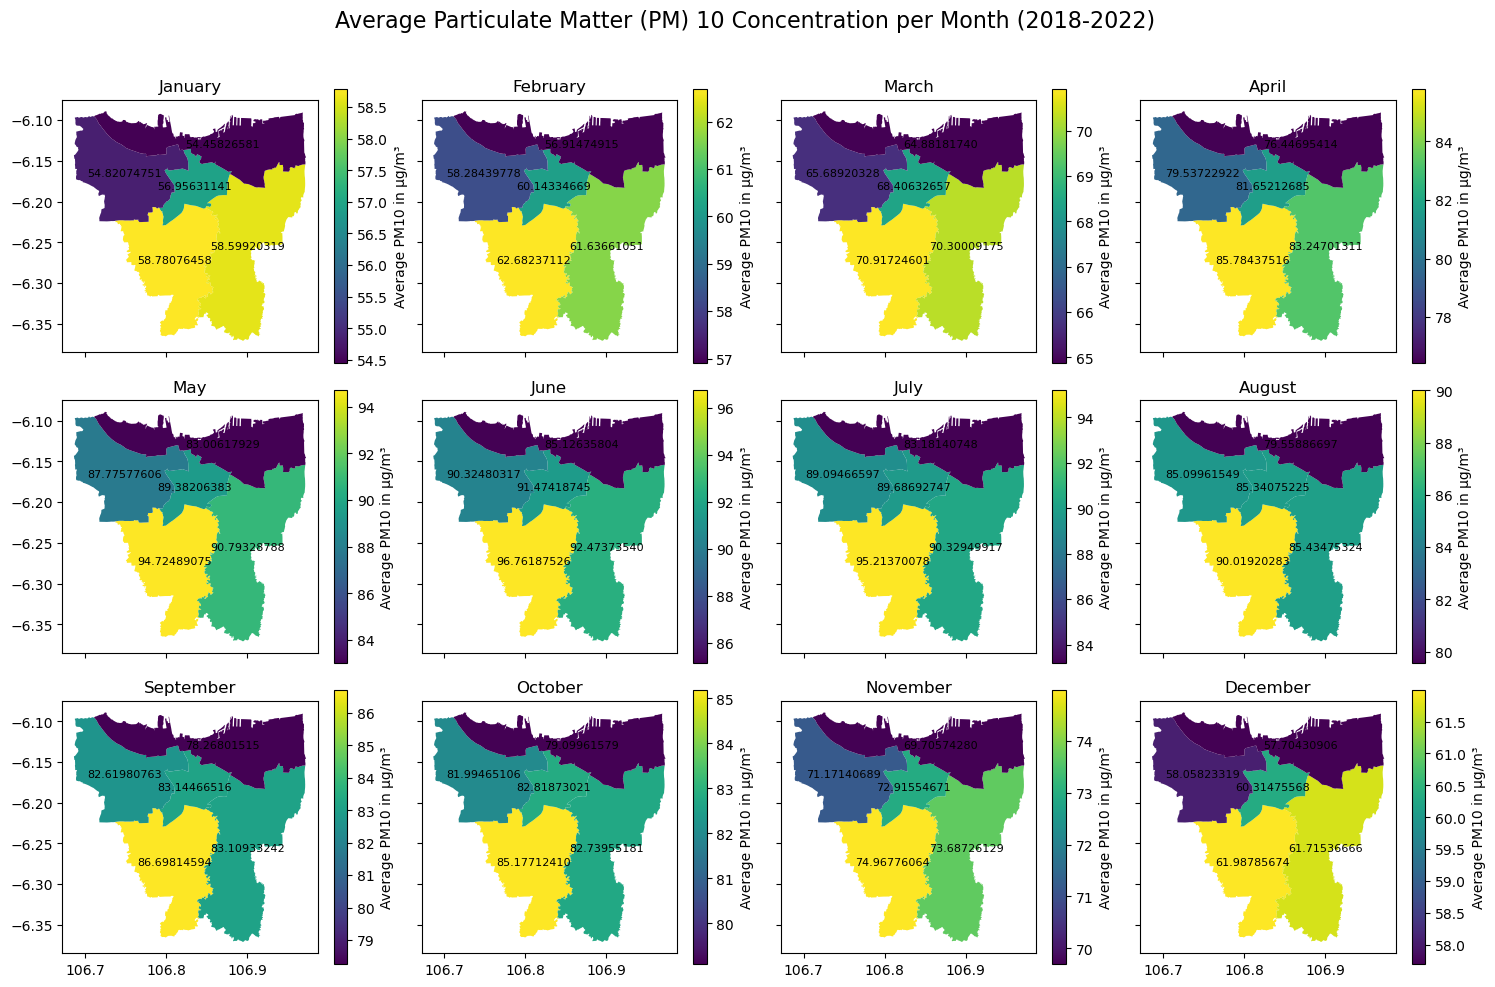

In [21]:
# Create a figure with subplots for each month
fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Average Particulate Matter (PM) 10 Concentration per Month (2018-2022)', fontsize=16)

# Iterate through each month and plot the data
for month, ax in zip(range(1, 13), axs.flatten()):
    # Filter data for the current month
    data_monthly = polygon_result[polygon_result['month'] == month]

    # Plot the map for the current month
    data_monthly.plot(ax=ax, column="pm10", legend=True, legend_kwds={"label": "Average PM10 in µg/m³"})

    # Annotate each polygon with average PM10 value
    for idx, row in data_monthly.iterrows():
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, f"{row['pm10']:.8f}", fontsize=8, ha='center', va='center')

    ax.set_title(calendar.month_name[month])  # Menggunakan modul calendar untuk mendapatkan nama bulan

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# If u want to change the color, use this script
# The colors are limited based on cmap
# Put these script before plt.show()
cmap = plt.get_cmap('plasma')
plt.set_cmap(cmap)
plt.show()

**GRAPHS**

In [22]:
import calendar

# Format for monthly graph
dissolved_result_df['month_name'] = pd.to_datetime(dissolved_result_df['month'], format='%m').dt.month_name()

# Set the ['month_name'] as an index
dissolved_result_df= dissolved_result_df.set_index('month_name')

JAKARTA BARAT
                   KABKOT  month  longitude  latitude    year       pm10  \
month_name                                                                 
January     JAKARTA BARAT      1     106.75 -6.158333  2020.0  54.820748   
February    JAKARTA BARAT      2     106.75 -6.158333  2020.0  58.284398   
March       JAKARTA BARAT      3     106.75 -6.158333  2020.0  65.689203   
April       JAKARTA BARAT      4     106.75 -6.158333  2020.0  79.537229   
May         JAKARTA BARAT      5     106.75 -6.158333  2020.0  87.775776   
June        JAKARTA BARAT      6     106.75 -6.158333  2020.0  90.324803   
July        JAKARTA BARAT      7     106.75 -6.158333  2020.0  89.094666   
August      JAKARTA BARAT      8     106.75 -6.158333  2020.0  85.099615   
September   JAKARTA BARAT      9     106.75 -6.158333  2020.0  82.619808   
October     JAKARTA BARAT     10     106.75 -6.158333  2020.0  81.994651   
November    JAKARTA BARAT     11     106.75 -6.158333  2020.0  71.171407  

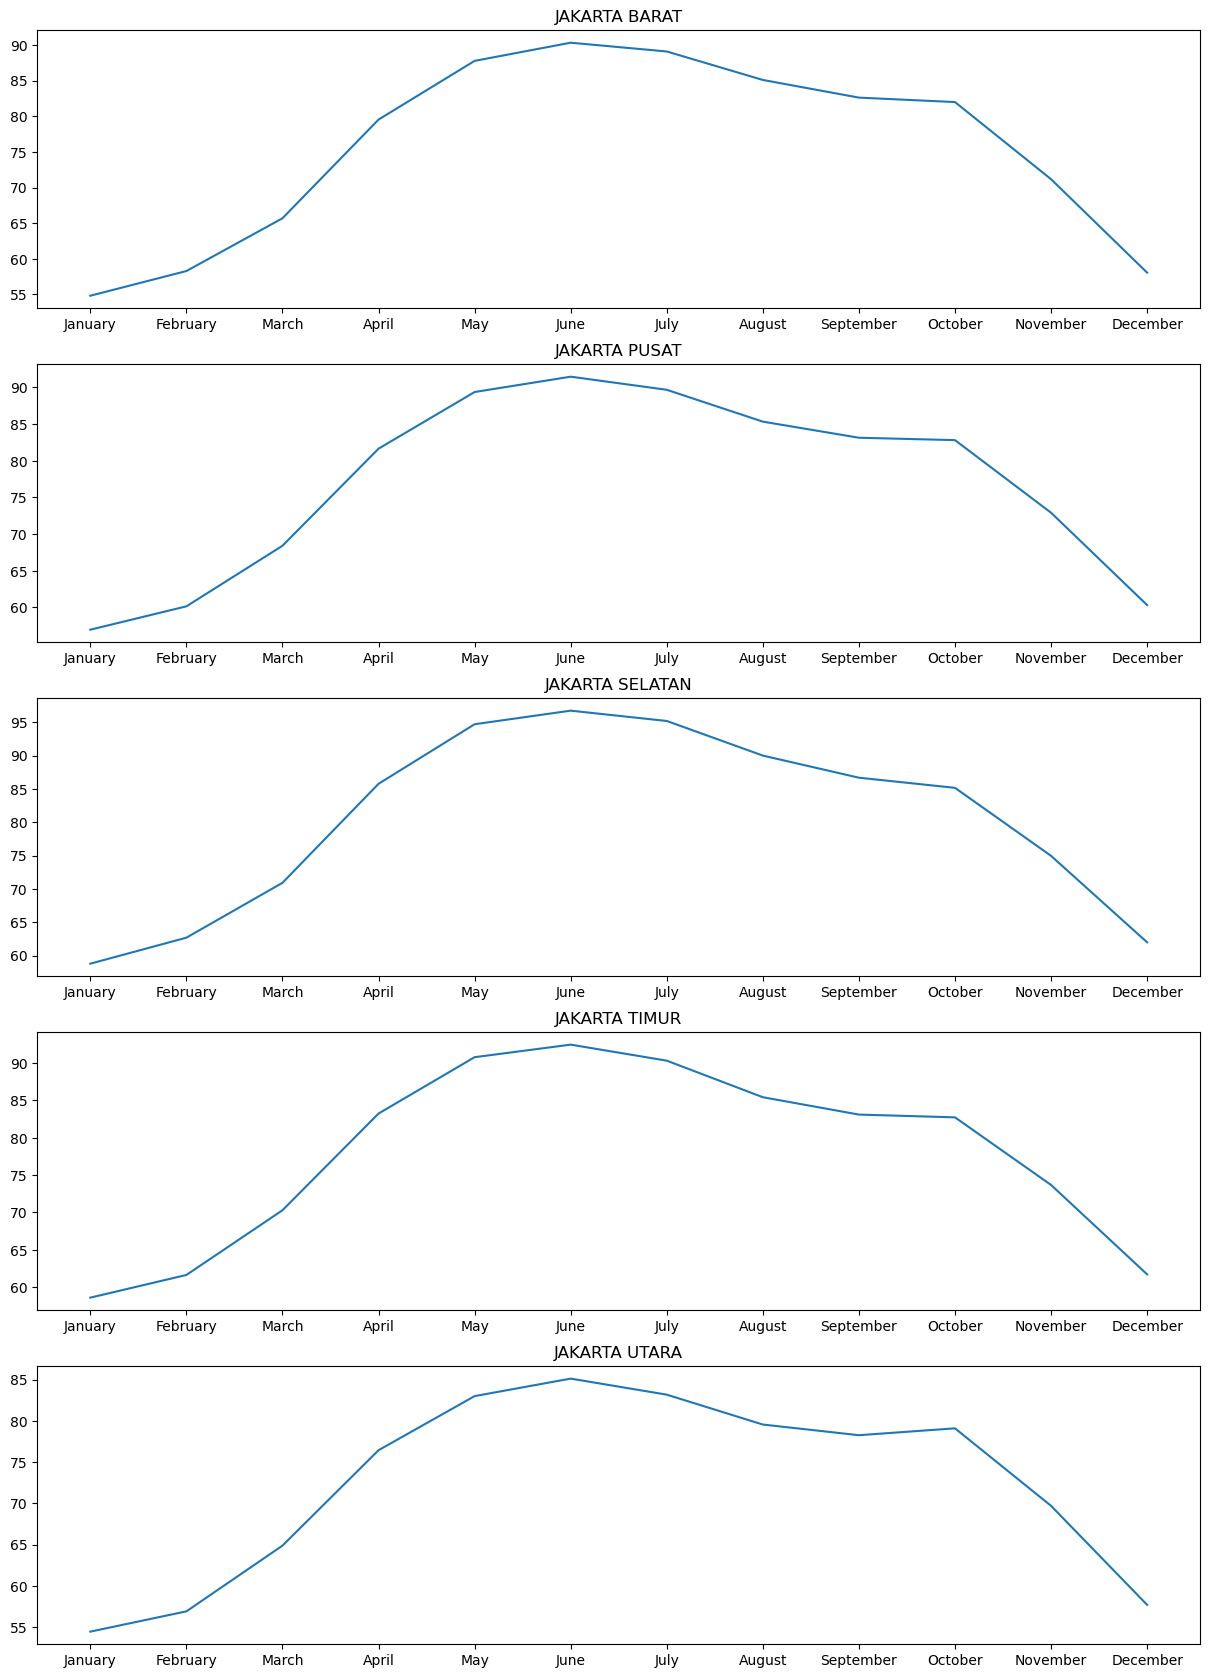

In [23]:
fig  = plt.figure(figsize=(15,60))
cities = list(dissolved_result_df['KABKOT'].unique())
# Iterate through each month and plot the data
for city, ax in zip(cities, range(1,6)):
    # Filter data for the current wilayah admin
    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]
    print(city)
    print(data_city)
    # Plot the map for the current kabkot
    fig.add_subplot(14, 1, ax)
    plt.plot(data_city['pm10'])
    plt.title(city)
    #ax.set_title(f'{city}')